<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/Video Labels.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/Video Labels.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/Video Labels.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/Video Labels.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# <span style="color:#FF6D04">**Video Labels in FiftyOne**

##  <span style="color:#A6A7A9">**A guided example with ASL videos**

First download and unzip the dataset.

We will be using the [WLASL Dataset](https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed), a dataset comprised of actors performing sign language.

In [ ]:
!pip install kaggle

In [106]:
!kaggle datasets download -d risangbaskoro/wlasl-processed

100%|█████████████████████████████████████▉| 4.82G/4.82G [02:14<00:00, 54.0MB/s]
100%|██████████████████████████████████████| 4.82G/4.82G [02:14<00:00, 38.4MB/s]


In [108]:
!mkdir wlasl-processed

In [ ]:
!unzip wlasl-processed.zip -d wlasl-processed

In [110]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os

Load in the labels for the dataset

In [158]:
main_path = './wlasl-processed/'
wlasl_df = pd.read_json(main_path + 'WLASL_v0.3.json')

In [159]:
wlasl_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [160]:
mp4_dir = main_path + "videos"

## <span style="color:#FF6D04">**Creating the Video Dataset**

In [161]:
import fiftyone

dataset = fo.Dataset.from_dir(dataset_dir=mp4_dir,dataset_type=fo.types.VideoDirectory)
dataset.ensure_frames()
dataset.compute_metadata()
dataset.name = 'wlasl-dataset'
dataset.persistent = True

 100% |█████████████| 11980/11980 [1.7s elapsed, 0s remaining, 7.2K samples/s]          
Computing metadata...
 100% |█████████████| 11980/11980 [1.2m elapsed, 0s remaining, 403.2 samples/s]      



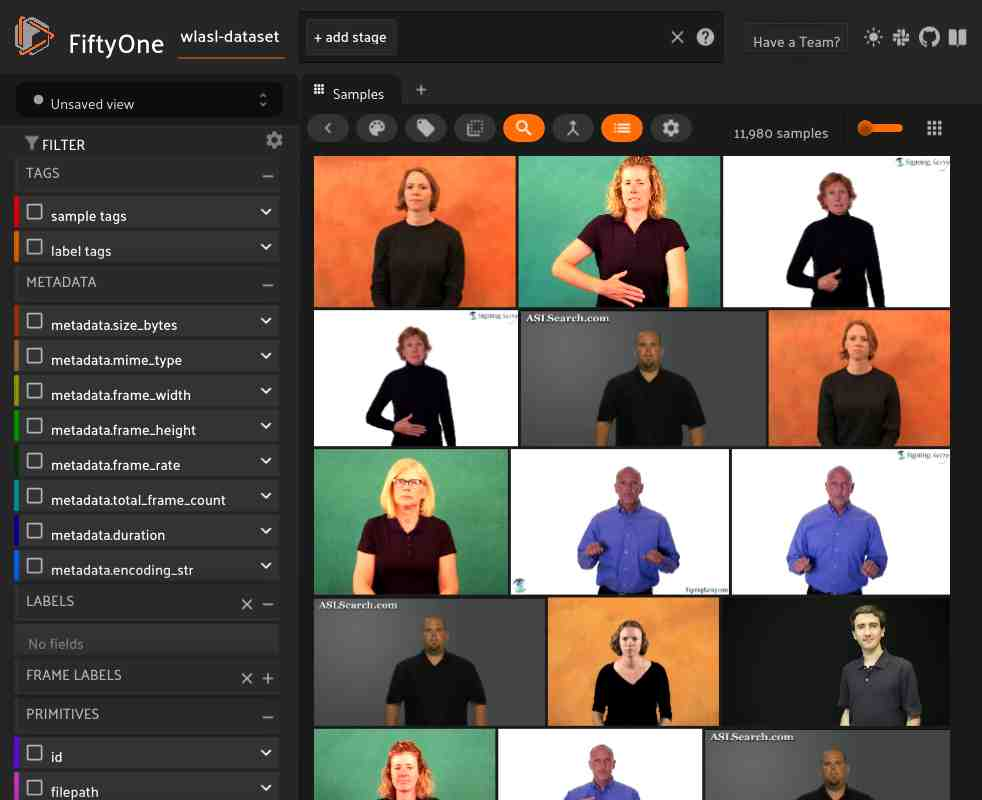


Could not connect session, trying again in 10 seconds



In [162]:
session = fo.launch_app(dataset)

## <span style="color:#FF6D04">**Sample Detections**

In [163]:
def find_row_by_video_id(dataframe, video_id):
    for index, row in dataframe.iterrows():
        for instance in row['instances']:
            if instance['video_id'] == video_id:
                return row, instance
    return None 

In [164]:
view = dataset.take(100)

In [165]:
for sample in view:
    base_file_name = os.path.basename(sample.filepath)
    video_id, extension = os.path.splitext(base_file_name)
    row, inst = find_row_by_video_id(wlasl_df,video_id)
    gloss = row["gloss"]
    bbox = inst["bbox"]
    imw = sample.metadata.frame_width
    imh = sample.metadata.frame_height
    x1 = bbox[0] / imw
    x2 = bbox[2] / imw
    y1 = bbox[1] / imh
    y2 = bbox[3] / imh
    bbox = [x1,y1,x2-x1,y2-y1]
    det = fo.Detection(bounding_box=bbox,label=gloss)
    sample['Sample Label'] = fo.Detections(detections=[det])
        
    sample.save()
    


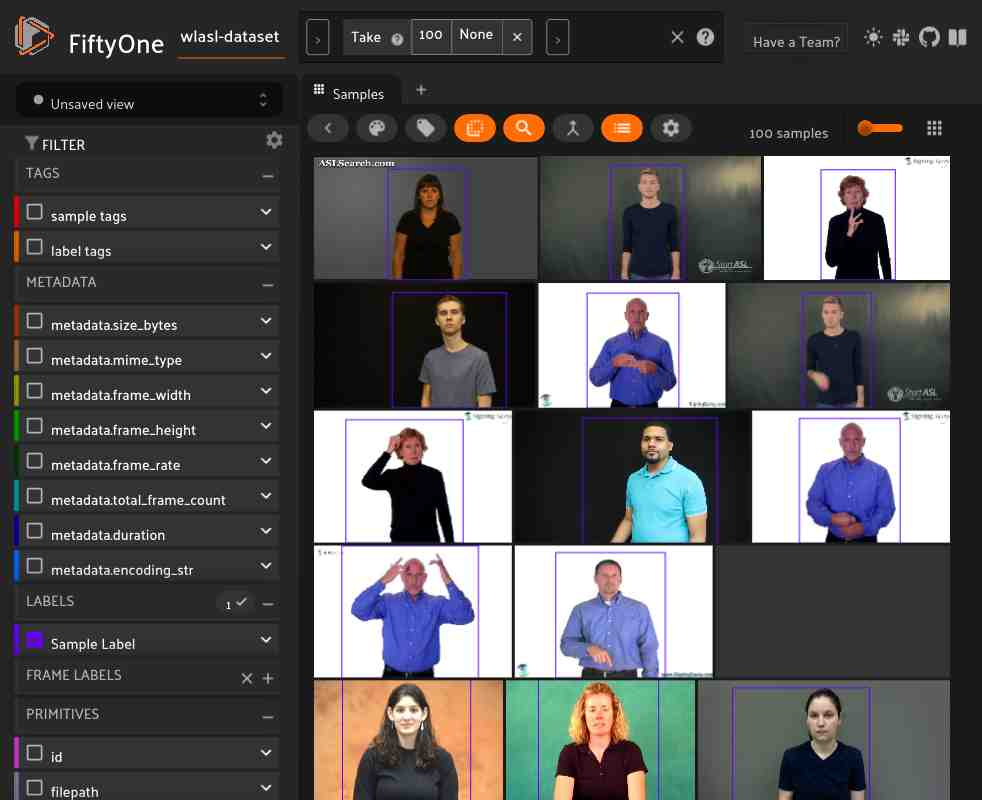

In [166]:
session.view = view

## <span style="color:#FF6D04">**Frame Level Detections**

In [167]:
def bigger_bbox(x, y, width, height, index):

    offset = 0.001
    x_offset = index*offset

    # Apply the offsets to the parameters
    n_x = x - x_offset
    n_width = width + x_offset*2 

    return [n_x, y, n_width, height]

In [168]:
for sample in view:
    base_file_name = os.path.basename(sample.filepath)
    video_id, extension = os.path.splitext(base_file_name)
    row, inst = find_row_by_video_id(wlasl_df,video_id)
    gloss = row["gloss"]
    bbox = inst["bbox"]
    imw = sample.metadata.frame_width
    imh = sample.metadata.frame_height
    x1 = bbox[0] / imw
    x2 = bbox[2] / imw
    y1 = bbox[1] / imh
    y2 = bbox[3] / imh
    bbox = [x1,y1,x2-x1,y2-y1]
    for frame_no, frame in sample.frames.items():
        new_bbox = bigger_bbox(bbox[0],bbox[1],bbox[2],bbox[3],frame_no)
        det = fo.Detection(bounding_box=new_bbox,label=gloss)
        frame['Frame Label'] = fo.Detections(detections=[det])
        
    sample.save()


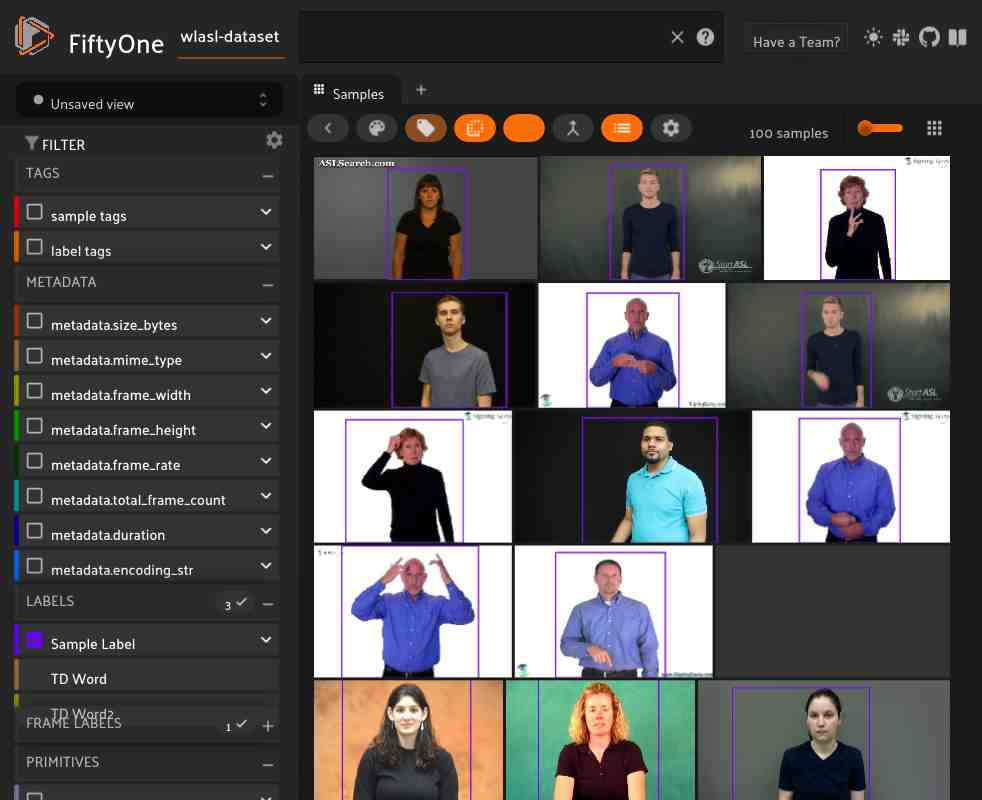

In [169]:
session.view = view

## <span style="color:#FF6D04">**Temporal Detections**

In [170]:
for sample in view:
    base_file_name = os.path.basename(sample.filepath)
    video_id, extension = os.path.splitext(base_file_name)
    row, inst = find_row_by_video_id(wlasl_df,video_id)
    gloss = row["gloss"]
    sample["TD Word"] = fo.TemporalDetection.from_timestamps(
    [0, sample.metadata.duration/2], label=gloss, sample=sample
    )
    sample["TD Word2"] = fo.TemporalDetection.from_timestamps(
    [sample.metadata.duration/2, sample.metadata.duration], label="ASL is awesome!", sample=sample
    )

        
    sample.save()
    


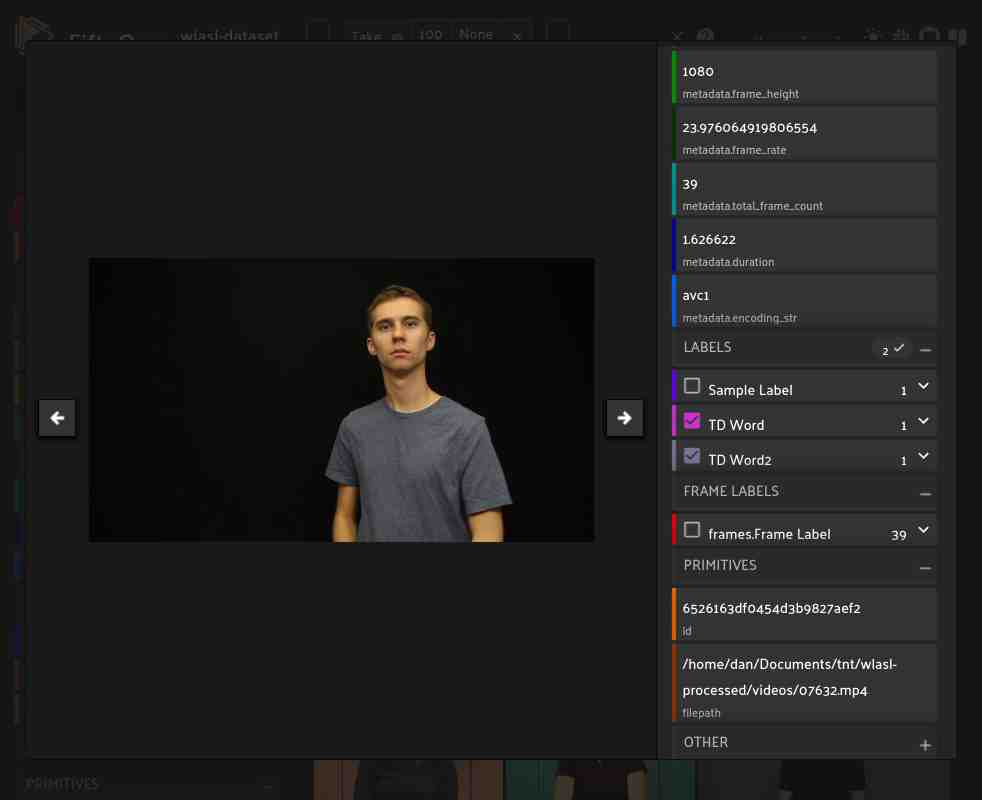

In [171]:
session.view = view

## <span style="color:#FF6D04">**Video Classification**

In [172]:
for sample in view:
    base_file_name = os.path.basename(sample.filepath)
    video_id, extension = os.path.splitext(base_file_name)
    row, inst = find_row_by_video_id(wlasl_df,video_id)
    gloss = row["gloss"]
    sample["class"] = fo.Classification(label=gloss)
        
    sample.save()
    

In [173]:
session.view = view

![Classification](video_label_imgs/asl_class.png)